# Kaggle Comp - Classical Music Meets Classical ML

## Assignment 

- https://www.kaggle.com/competitions/classical-music-meets-clasical-ml-spring-2025/data

### Data
- Our task is to build a model to predict which previous patrons will purchase
a subscription to the 2014-15 concert season
- We are given a subset of patrons along with a 0/1 label indicating whether they
purchased a 2014-15 season subscription (train.csv)
- We are given a test set containing accounts to generate predictions (test.csv)
- We are also given several other datafiles:
    - Account.csv: location info for each patron and donation history
    - Tickets_all.csv: previously purchased tickets by account - season, location, set, price level, # seats
    - Subscriptions.csv: previously purchased subscriptions by account – season, location, price level, # seats
    - Concerts.csv: previous concerts by season – title, composer, location
    - Concerts_2014-15.csv: list of planned 2014-15 sets
    - zipcodes.csv: information about zip codes

### Approach
- Determine possible features
- Create a data pipeline to build features (both train and test)
    - Clean data
    - Generate features
    - Prepare data for modeling
- Perform modeling (validation approach) 
    - Feature engineering & selection
    - Evaluate algorithms
    - Tune hyperparameters
    - Possibly create ensembles

### Scoring
- We will use AUROC to score your probabilistic predictions
  - Kaggle will automatically calculate it for you when you upload your predictions
- Test set is divided into public and private test sets
- Public leaderboard will show your performance on the public test set
- Your final leaderboard position will depend on the private test set
    - This prevents any attempt to “game the system”
- Your grade will be calculated based on your private test set performance
- Your grade will depend on three parts:
    – Your score on the private test set (70 points)
    – Your code hygiene (10 points)
        - All submission code must be in python scripts (no notebooks)
        - Code should be organized (functions & classes), no loose code
        - Code should be easy to follow and reasonably documented (docstrings for
functions and classes)
    - Your writeup of your modeling process (20 points)
        - README doc describing your data pipeline and modeling approach
        - Must be understandable and sufficiently detailed

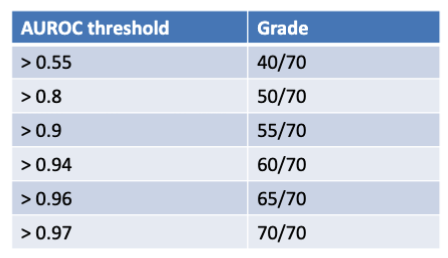

## Data

For each dataset, understand what's furnished, clean it, and encode any categoricals for to allow for correlation matrix, pairplot, etc... to help understand distribution, etc... (we can't do a distribution on a column of strings). 

❗️ A heuristic search of the predictors, normalization, encoding, engineered features, hyperparameters,...  seems inefficient and unlikely to yield good results in particular due to my lack of appreciation of the underlying domain. Perhaps the box office could tell you that county of residence and a love of vivaldi are the most likely inputs to correlate with subscriptions, but I can't. It will be a lot less work and a lot more fun to leave the search to the computer. So, when there is a decision, for example how to treat international zip codes, instead of picking a path and then hoping I remember to come back and run an experiment on the alternative path, code both as potential configurations or inputs that we can iterate over to find the optimal setup. 
- We could bias toward building a cuckoo-bananas-big dataframe with all the possible features in it and letting L1 regularization crush the unhelpful inputs
- We could somehow keep running tabs of these alternatives and exhaustively search all the permutations for the best outcome
- We could build a model to select the principle components and train on those

Whatever we do, don't lose track of these decisions and ensure they are explored automatically. It's possible we'll get everything dialed in and then realize we missed a key insight or optimization and we'll need to reun all the alternatives again. The easiest thing to start with is the CBBDF, just keep adding columns, we can optimize them away later but this gives us an easy option for running a correlation matrix, heatmap, etc... 
- However, the CBBDF doesn't help us integrate some of the data which has a 1-many relationship with the accounts. for example, account xyz might have purchased 20 tickets last year, have various historical donations and be on a marketing list twice... how does this get rolled up in to the CBBDF? lots of decisions to be made here.
    - do historical ticket purchases get rolled up into one number? what about the timing of those purchases? you could have had a benefactor 5 years ago that died but the temporal component of the donations is lost when you aggregate in such a naive way 
    - if we sum historical subscription info, we lose the location, price level, section and sub tier of each ... surely this information is relevant, or at least it coudl be and excluding seems short-sighted.

❗️ To do: 
 - get all data into numerical format to enable basic predictions
 - decide whether all data needs to be standardized

**Data Model** 

We are interested in predicting purchase probability, based solely on the account number of the customer. At the highest level we have then 
- an account, which has exactly one of each of the following features in the dataset
    - id
    - zip (it feels safe to collapse shipping zip, billing zip into a single, normalized value)
    - city (could conflict with zip, but i think it's safe to collapse this into the city yielded by the ZIP lookup whether or not they match)
    - relationship - categorical, nature of relationship to business
    - amount donated last year
    - amount donated lifetime
    - number of lifetime donations
    - date first donated
... and $0 - k$ of these
    - subscriptions, list of prior subscriptions - longer history than tickets but overlaps
        - season
        - package
        - number of seats
        - location
        - section
        - price
        - tier
        - multiple subscription indicator
    - tickets, list of prior purchases - only runs for a few years
        - price,
        - number of seats
        - marking sourc
        - season
        - location
        - set (maps to concert info given the season above) 
        - multiple ticket buyer indicator

Reference info that extends one or more of above, but doesn't change dimensionality
- concerts, historical listing of concerts with
    - season 
    - concert name
    - who performed it
    - what was performed
    - where it was performed (of the few locs possible)
- zip reference, which has one of each of the following relevant features
    - Zipcode
    - ZipCodeType
    - City
    - State
    - Lat
    - Long
    - Decommisioned
    - TaxReturnsFiled
    - EstimatedPopulation
    - TotalWages

We have to assume that tickets are individual purchases or additional seats for guests, and that subscriptions guarantee the subscriber some number of seats or a reserved seat at every performance. 
 
And the following information which seems to be floating in space. This isn't associated with any subscriber, but their prior history is what should condition the likelihood that they'll buy this year. So, like $P(subscribe|concerts)$. We do have *some* labeled data for this concert season, that could be what we train a bayesian model on. 

- concerts coming up
    - concert name
    - who is performing
    - what is being performed
    - where 

In [98]:
!ls data

account.csv           sample_submission.csv train.csv
account_clean.csv     subscriptions.csv     zipcodes.csv
concerts.csv          test.csv
concerts_2014-15.csv  tickets_all.csv


In [99]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

### Train Set

In [100]:
# Subset of accounts/patrons and whether they purchased a 2014-2015 subscription
train_df = pd.read_csv('data/train.csv', index_col='account.id')
train_df.head() 

,label
account.id,
001i000000NuRo3,0
001i000000NuRxd,0
001i000000NuQGN,0
001i000000NuPfL,0
001i000000NuQkP,0


In [101]:
train_df.dtypes

label    int64
dtype: object

In [102]:
train_df.count()

label    6941
dtype: int64

In [103]:
train_df[train_df['label']==1].count()

label    332
dtype: int64

In [104]:
# Super imbalanced classes here...

### Predict Set

In [105]:
# Test set containing accounts to generate predictions for 
test_df = pd.read_csv('data/test.csv', index_col='ID') 
test_df.head()

""
ID
001i000000NuQ6Y
001i000000NuQXz
001i000000NuRDC
001i000000NuQeg
001i000000NuOQc


In [106]:
test_df.dtypes

Series([], dtype: object)

In [107]:
test_df.count()

Series([], dtype: int64)

### Zip code reference

**Feature audit** 
- ZipCodeType
    - one of standard, DPO, PO BOX...
- LocationType
    - Can be dropped, just a single value
- Lat/long
- Location
    - Coding for continent, country, state, city
    - Drop this
- Decommissioned
    - Binary, some number of zip codes are apparently no longer used
    - 663 of 41K+
- TaxReturnsFiled
- EstimatedPop
    - Seems plausible
    - for 27603 reports 19277 tax returns, 33789 population and 836M in total wages
- TotalWages
    - ~30K zip codes report this and the two features above... what are they?
    - Blanks aren't correlated with the states
    - Wages/population seems like a great feature to engineer...

In [108]:
zip_df = pd.read_csv('data/zipcodes.csv') 
display(zip_df.head())
display(zip_df.tail())

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,False,NaN,NaN,NaN
1,610,STANDARD,ANASCO,PR,PRIMARY,18.28,-67.14,NA-US-PR-ANASCO,False,NaN,NaN,NaN
2,611,PO BOX,ANGELES,PR,PRIMARY,18.28,-66.79,NA-US-PR-ANGELES,False,NaN,NaN,NaN
3,612,STANDARD,ARECIBO,PR,PRIMARY,18.45,-66.73,NA-US-PR-ARECIBO,False,NaN,NaN,NaN
4,601,STANDARD,ADJUNTAS,PR,PRIMARY,18.16,-66.72,NA-US-PR-ADJUNTAS,False,NaN,NaN,NaN


,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
42517,34009,MILITARY,APO,AA,PRIMARY,NaN,NaN,SA-GY-NEW HORIZON-GUYANA,True,NaN,NaN,NaN
42518,34010,MILITARY,APO,AA,PRIMARY,NaN,NaN,CA-HN-NEW HORIZON LA CEIBA - COMAYAGUA,True,NaN,NaN,NaN
42519,34001,MILITARY,APO,AA,PRIMARY,NaN,NaN,CA-NI-JTF JUNTOS PODEMOS BASE CAMP,True,NaN,NaN,NaN
42520,34071,MILITARY,APO,AA,PRIMARY,NaN,NaN,SA-PY-JTF NEW HORIZON-CONCEPCION,True,NaN,NaN,NaN
42521,97475,PO BOX,SPRINGFIELD,OR,PRIMARY,44.05,-123.02,NA-US-OR-SPRINGFIELD,False,NaN,NaN,NaN


In [109]:
zip_df.columns

Index(['Zipcode', 'ZipCodeType', 'City', 'State', 'LocationType', 'Lat',
       'Long', 'Location', 'Decommisioned', 'TaxReturnsFiled',
       'EstimatedPopulation', 'TotalWages'],
      dtype='object')

In [110]:
zip_df.dtypes

Zipcode                  int64
ZipCodeType             object
City                    object
State                   object
LocationType            object
Lat                    float64
Long                   float64
Location                object
Decommisioned             bool
TaxReturnsFiled        float64
EstimatedPopulation    float64
TotalWages             float64
dtype: object

In [111]:
def canonicalize_zip(zip, print_invalid=False) -> int: 
    out = 0
        
    if int == type(zip): 
        if zip > 0 and zip < 99950: 
            out = zip
        else: 
            pass 
            
    if str == type(zip):
        
        if zip.isdigit(): 
            # 3-digit ZIP (PR) missing the leading zeros 
            if len(zip) == 3: 
                out = int(zip) 
            
            # 4-digit missing a leading zero (e.g. some NJ, mass zips)
            elif len(zip) == 4: 
                out = int(zip) 
                
            # 5-digit ZIP
            elif len(zip) == 5: 
                out = int(zip) 

            else: 
                pass
                
        elif len(zip) > 5 and zip[5] == '-':
            out = int(zip[0:5]) 

        else: 
            
            pass
    else: 
        pass 

    if out is None and print_invalid: 
        print(f"Ignoring unknown ZIP format:{zip}")

    return(out) 

def code_international(zip) -> bool: 
    intl = 0
        
    if str == type(zip):
        if not zip.isdigit(): 
            intl = 1
            if len(zip) == 10 and zip[5] == '-':
                intl = 0

    return(intl) 

In [112]:
zip_df['Zipcode'].apply(canonicalize_zip, args=[True]) 

0          705
1          610
2          611
3          612
4          601
         ...  
42517    34009
42518    34010
42519    34001
42520    34071
42521    97475
Name: Zipcode, Length: 42522, dtype: int64

In [113]:
# All zips here are healthy, no massaging required

In [114]:
zip_df['ZipCodeType'].unique()

array(['STANDARD', 'PO BOX', 'UNIQUE', 'MILITARY'], dtype=object)

In [115]:
zip_df['TaxReturnsFiled'].unique()

array([   nan, 13245.,  2945., ...,  1289., 24012., 15865.])

In [116]:
zip_df['EstimatedPopulation'].unique()

array([   nan, 24083.,  5471., ..., 29471., 43717., 30483.])

In [117]:
zip_df['TotalWages'].unique()

array([           nan, 1.08909504e+09, 3.25436960e+08, ...,
       8.82055221e+08, 4.38123710e+07, 6.71941190e+07])

In [118]:
zip_df.drop(['Decommisioned'], axis=1, inplace=True)

### Patron location and donation history

**Feature summary**  
- Shipping ZIP:
    - where they are alphnumeric, they correspond to a non-US location, which could be an important signal ... if we do an inner join with the ZIP data we'll lose this information, as there is no reference info for foreign mailing codes 
    - maybe 1% of the rows have these listed!
- Billing ZIPs:
    - same here as above, try to preserve the foreign residence if we join with ZIP... perhaps a separate column (international)
    - maybe 70% of rows include a billing zip
- Shipping city:
    - These entries almost always have an associated shipping ZIP
    - Maybe 1% of entries include this info
- Billing city:
    - Similar to billing ZIP in terms of prevalnce
    - Almost always have a billing ZIP

- A number of these accounts are blank in both ZIP columns
    - maybe 20% of the accounts -- we can't reject these!
    - a number have foreign addresses in billing city, e.g. 'Brumadinho, MG', 'Halifax', 'Kwun Tong'
- Relationship:
    - There are just a handful of `relationship` categories, we could one-hot encode these, but man this doesn't scale well... we'll have super sparse and confusing DFs if we one-hot encode everything. Maybe this is a decision point we should track? I.e. build a pipeline that can do alternative encodings in the future if we want?
        - How about the sklearn.OneHotEncoder, etc... can we chain together sklearn.preprocessing transformers in arbitrary order?
        - ❗️ TODO encode 'relationship'
- amount.donated.2013:
    - very few donations here
    - probably an extremely relevant predictor
- amount.donated.lifetime:
    - more than 2013, but still relatively few accounts
- no.donations.lifetime:
    - number of donations, presumably
- first.donated
    - ❗️convert these to floats and standardize? they should be scaled to the full range of included dates, right? 

In [119]:
# Presence of 0xc3 character suggests account.csv is encoded with ISO-8859-2
account_df = pd.read_csv('data/account.csv', encoding='ISO-8859-2', index_col='account.id')
account_df

,shipping.zip.code,billing.zip.code,shipping.city,billing.city,relationship,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,first.donated
account.id,,,,,,,,,
001i000000LhSrQ,94102,94102,San Francisco,San Francisco,NaN,0.0,0.0,0,NaN
001i000000LhyPD,NaN,94303,NaN,Palo Alto,NaN,0.0,500.0,5,1987-07-04 00:00:00
001i000000LhyPE,NaN,94597,NaN,Walnut Creek,NaN,0.0,783.0,7,2008-06-02 00:00:00
001i000000LhyPF,NaN,94610,NaN,Oakland,NaN,1500.0,28435.0,28,1986-07-04 00:00:00
001i000000LhyPG,NaN,94024,NaN,Los Altos,NaN,300.0,4969.0,16,1997-04-07 00:00:00
...,...,...,...,...,...,...,...,...,...
001i0000018BZTP,NaN,95014,NaN,Cupertino,NaN,0.0,0.0,0,NaN
001i0000018BZTt,NaN,94521,NaN,Concord,NaN,0.0,0.0,0,NaN
001i0000018BZUN,NaN,94552,NaN,castro valley,NaN,0.0,0.0,0,NaN


In [120]:
account_df.to_csv('data/account_clean.csv') 

In [121]:
account_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19833 entries, 001i000000LhSrQ to 001i0000018Bbdd
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   shipping.zip.code        264 non-null    object 
 1   billing.zip.code         16878 non-null  object 
 2   shipping.city            272 non-null    object 
 3   billing.city             17615 non-null  object 
 4   relationship             661 non-null    object 
 5   amount.donated.2013      19833 non-null  float64
 6   amount.donated.lifetime  19833 non-null  float64
 7   no.donations.lifetime    19833 non-null  int64  
 8   first.donated            5535 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.5+ MB


In [122]:
account_df.dtypes

shipping.zip.code           object
billing.zip.code            object
shipping.city               object
billing.city                object
relationship                object
amount.donated.2013        float64
amount.donated.lifetime    float64
no.donations.lifetime        int64
first.donated               object
dtype: object

In [123]:
account_df.shape

(19833, 9)

In [124]:
account_df['shipping.zip'] = account_df['shipping.zip.code'].apply(canonicalize_zip, args=[False]) 

In [125]:
account_df['billing.zip'] = account_df['billing.zip.code'].apply(canonicalize_zip, args=[False]) 

In [126]:
account_df['international'] = account_df['billing.zip.code'].apply(code_international)

In [127]:
account_df.drop(['shipping.zip.code', 'billing.zip.code'], axis=1, inplace=True) 

In [128]:
# Consider a binary encoding of each of the 5 digits for zip

In [129]:
account_df.rename(columns={'billing.zip': 'Zipcode'}, inplace=True)

In [130]:
account_df['Zipcode'] = account_df['Zipcode'].astype(int)

In [131]:
zip_df.set_index('Zipcode', inplace=True)

In [132]:
account_df = account_df.join(other=zip_df, on='Zipcode', how='left', lsuffix='_a', rsuffix='_z')

In [133]:
def compute_wpc(population, wages): 
    return wages/population

In [134]:
# With help from https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe
account_df['wages.per.capita'] = account_df.apply(lambda x: compute_wpc(x.EstimatedPopulation, x.TotalWages), axis=1)

In [135]:
account_df['wages.per.capita'] = account_df['wages.per.capita'].fillna(value=0) 

In [136]:
account_df['Lat'] = account_df['Lat'].fillna(value=0) 
account_df['Long'] = account_df['Long'].fillna(value=0) 

In [137]:
account_df.head() 

,shipping.city,billing.city,relationship,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,first.donated,shipping.zip,Zipcode,international,...,City,State,LocationType,Lat,Long,Location,TaxReturnsFiled,EstimatedPopulation,TotalWages,wages.per.capita
account.id,,,,,,,,,,,,,,,,,,,,,
001i000000LhSrQ,San Francisco,San Francisco,NaN,0.0,0.0,0,NaN,94102,94102,0,...,SAN FRANCISCO,CA,PRIMARY,37.77,-122.41,NA-US-CA-SAN FRANCISCO,12542.0,16733.0,4.808331e+08,28735.618120
001i000000LhyPD,NaN,Palo Alto,NaN,0.0,500.0,5,1987-07-04 00:00:00,0,94303,0,...,PALO ALTO,CA,PRIMARY,37.45,-122.10,NA-US-CA-PALO ALTO,18392.0,34099.0,1.243741e+09,36474.409895
001i000000LhyPE,NaN,Walnut Creek,NaN,0.0,783.0,7,2008-06-02 00:00:00,0,94597,0,...,WALNUT CREEK,CA,PRIMARY,37.91,-122.07,NA-US-CA-WALNUT CREEK,10755.0,16977.0,6.592431e+08,38831.542145
001i000000LhyPF,NaN,Oakland,NaN,1500.0,28435.0,28,1986-07-04 00:00:00,0,94610,0,...,OAKLAND,CA,PRIMARY,37.81,-122.24,NA-US-CA-OAKLAND,16601.0,24162.0,1.004840e+09,41587.634136
001i000000LhyPG,NaN,Los Altos,NaN,300.0,4969.0,16,1997-04-07 00:00:00,0,94024,0,...,LOS ALTOS,CA,PRIMARY,37.34,-122.11,NA-US-CA-LOS ALTOS,10923.0,20665.0,1.585532e+09,76725.485700


In [138]:
from sklearn.preprocessing import LabelEncoder

def label_feature(df, column): 
    """
    Scale a column in a DF to the provided range     
    """
    labeler = LabelEncoder()
    labels = labeler.fit_transform(df[column])
    return labels

In [139]:
account_df['zip.type.encoded'] = label_feature(account_df, 'ZipCodeType')

In [140]:
account_df.drop(['shipping.city', 'shipping.zip', 'ZipCodeType', 'City', 'State', 'Location', 'LocationType', 'TaxReturnsFiled', 'EstimatedPopulation', 'TotalWages'], axis=1, inplace=True) 

In [141]:
account_df['relationship.encoded'] = label_feature(account_df, 'relationship')

In [142]:
account_df.drop(['relationship'], axis=1, inplace=True)

In [143]:
from datetime import datetime

In [144]:
basetime = datetime(1970, 1, 1)

In [145]:
account_df.head()

,billing.city,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,first.donated,Zipcode,international,Lat,Long,wages.per.capita,zip.type.encoded,relationship.encoded
account.id,,,,,,,,,,,,
001i000000LhSrQ,San Francisco,0.0,0.0,0,NaN,94102,0,37.77,-122.41,28735.618120,2,10
001i000000LhyPD,Palo Alto,0.0,500.0,5,1987-07-04 00:00:00,94303,0,37.45,-122.10,36474.409895,2,10
001i000000LhyPE,Walnut Creek,0.0,783.0,7,2008-06-02 00:00:00,94597,0,37.91,-122.07,38831.542145,2,10
001i000000LhyPF,Oakland,1500.0,28435.0,28,1986-07-04 00:00:00,94610,0,37.81,-122.24,41587.634136,2,10
001i000000LhyPG,Los Altos,300.0,4969.0,16,1997-04-07 00:00:00,94024,0,37.34,-122.11,76725.485700,2,10


In [146]:
account_df['first.donated'] = pd.to_datetime(account_df['first.donated'])

In [147]:
account_df['first.donated'] = pd.to_numeric(account_df['first.donated'].fillna(basetime))

In [148]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale(df, column, range=(0,1)): 
    """
    Scale a column in a DF to the provided range     
    """
    scaler = MinMaxScaler(feature_range=range)
    scaled = scaler.fit_transform(df[[column]]) 
    return scaled.transpose()[0]

In [149]:
account_df['first.donated.scaled'] = min_max_scale(account_df, 'first.donated')

In [150]:
account_df.drop(['first.donated'], axis=1, inplace=True)

In [151]:
account_df.head()

,billing.city,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,zip.type.encoded,relationship.encoded,first.donated.scaled
account.id,,,,,,,,,,,,
001i000000LhSrQ,San Francisco,0.0,0.0,0,94102,0,37.77,-122.41,28735.618120,2,10,0.000000
001i000000LhyPD,Palo Alto,0.0,500.0,5,94303,0,37.45,-122.10,36474.409895,2,10,0.391632
001i000000LhyPE,Walnut Creek,0.0,783.0,7,94597,0,37.91,-122.07,38831.542145,2,10,0.859593
001i000000LhyPF,Oakland,1500.0,28435.0,28,94610,0,37.81,-122.24,41587.634136,2,10,0.369272
001i000000LhyPG,Los Altos,300.0,4969.0,16,94024,0,37.34,-122.11,76725.485700,2,10,0.610022


With the ZIPs joined, we have two floats that are great proxies for the city in lat/long, however many accounts don't have ZIPs! There are two situations here: 
1. We have a billing city
2. We have NO geographic information 

- We could map the billing city to a city in the ZIP file and use that info, but there are only 231 occurrences ... for now just ignore it and 
- Should we train a separate model to predict where no geographic data is available? Geographic anchoring contributes many useful features.
    - ❗️ Slice the data two ways after cleaning: 1) everything with geo info and its correlates (this will be fewer rows) 2) everything minus the geographic information (all rows maintained unless we have a similar dearth of info elsewhere in the accounts)

In [152]:
account_df.drop(['billing.city'], axis=1, inplace=True)

In [153]:
account_df.head()

,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,zip.type.encoded,relationship.encoded,first.donated.scaled
account.id,,,,,,,,,,,
001i000000LhSrQ,0.0,0.0,0,94102,0,37.77,-122.41,28735.618120,2,10,0.000000
001i000000LhyPD,0.0,500.0,5,94303,0,37.45,-122.10,36474.409895,2,10,0.391632
001i000000LhyPE,0.0,783.0,7,94597,0,37.91,-122.07,38831.542145,2,10,0.859593
001i000000LhyPF,1500.0,28435.0,28,94610,0,37.81,-122.24,41587.634136,2,10,0.369272
001i000000LhyPG,300.0,4969.0,16,94024,0,37.34,-122.11,76725.485700,2,10,0.610022


In [154]:
# Seaborn pairplot once we have data encoded 100% numerically
#sns.pairplot(account_df) 

### Previous year's ticket purchases

**Feature summary** 

- price.level
    - integers from 0 - 4, plus 'adult', 'GA', 'youth' and blanks
- no.seats
    - integers ranging from 1 - 34
- marketing.source
    - categorical, 15 different values
- season
    - categorical, 4 seasons included
- location
    - mess! a few diffrent values, categorical
- set
    - int, 1-8 + blanks
- multiple.tickets
    - boolean (yes/no) 

In [155]:
tickets_df = pd.read_csv('data/tickets_all.csv') 
tickets_df.head()

,account.id,price.level,no.seats,marketing.source,season,location,set,multiple.tickets
0,001i000000NuOP0,4,2,NaN,2012-2013,San Francisco,4.0,no
1,001i000000NuOYU,1,1,Other,2013-2014,Berkeley Sunday,6.0,no
2,001i000000NuRS9,4,2,NaN,2011-2012,Family concert,3.0,no
3,001i000000NuRPj,3,1,Postcard or brochure,2013-2014,Berkeley Saturday,2.0,no
4,001i000000NuRQ1,2,2,NaN,2013-2014,Berkeley Saturday,1.0,no


In [156]:
tickets_df.dtypes

account.id           object
price.level          object
no.seats              int64
marketing.source     object
season               object
location             object
set                 float64
multiple.tickets     object
dtype: object

In [157]:
tickets_df.shape

(2808, 8)

In [158]:
len(tickets_df['account.id'].unique()) 

2049

### Previous subscriptions by account 

**Feature summary** 
- season
    - categorical, going back 10+ seasons
- package:
    - categorical, maybe 10 values
- no.seats
    - int
    - 1-26
- location
    - categorical
    - same as 'location' indicated in last year's ticket purchases
- section
    - categorical
    - same as last year's ticket purchase categorical, but seems to have more values
- price.level
    - int
    - 0-4 and blank rows
- subscription_tier
    - 0 - 26 in half integer increments?
- multiple.subs
    - binary (yes/no)

In [159]:
subs_df = pd.read_csv('data/Subscriptions.csv') 
subs_df.head() 

,account.id,season,package,no.seats,location,section,price.level,subscription_tier,multiple.subs
0,001i000000LhyR3,2009-2010,Quartet,2,San Francisco,Premium Orchestra,1.0,1.0,no
1,001i000000NuOeY,2000-2001,Full,2,San Francisco,Orchestra,2.0,2.0,no
2,001i000000NuNvb,2001-2002,Full,2,Berkeley Saturday,Balcony Front,3.0,2.0,no
3,001i000000NuOIz,1993-1994,Quartet,1,Contra Costa,Orchestra,2.0,0.5,no
4,001i000000NuNVE,1998-1999,Full,2,Berkeley Sunday,Balcony Rear,4.0,2.0,no


In [160]:
subs_df.dtypes

account.id            object
season                object
package               object
no.seats               int64
location              object
section               object
price.level          float64
subscription_tier    float64
multiple.subs         object
dtype: object

In [161]:
subs_df.shape

(28627, 9)

In [162]:
len(subs_df['account.id'].unique())

6267

### Concerts by season

**Feature summary** 
- season
    - categorical, same as listed above in subscriptions
- concert.name
    - short name for a tuple of 'who'/'what' -- robert levin plays mozart indicates robert is the who and mozart is the what
- set
    - int
    - unique identifier for concert name, appears to be 1:1
- who
    - name of conductor, other persons of note performing
- what
    - the name of the piece or pieces being performed
    - ❗️ is there a way to represent these in a meaningful way short of embedding? can we extract entities and do a one-hot encoding? we certainly have to figure out who went to see what historically, and then allow for the same 'what' to be a predictor for who will go to see it this season
    - perhaps we do a poor-man's entity extraction by grabbing anything in all CAPS... this yields the composer at least from the 'what' column
- location
    - ❗️one of a small number of places presumably this classical music rotates through, also seems likely to be a factor in who will subscribe/attend -- how do we make this available in the dataset if it's a lower 'level' than our primary classification task

In [163]:
concerts_df = pd.read_csv('data/Concerts.csv') 
concerts_df[concerts_df['season']=='2013-2014']

,season,concert.name,set,who,what,location
83,2013-2014,Pergolesi in Naples,1,"Nicholas McGegan, conductor\rDavid Daniels, co...",HANDEL\rDuet ÒIo tÕabbraccioÓ from Rodelinda\r...,Berkeley Saturday
84,2013-2014,Pergolesi in Naples,1,"Nicholas McGegan, conductor\rDavid Daniels, co...",HANDEL\rDuet ÒIo tÕabbraccioÓ from Rodelinda\r...,Berkeley Sunday
85,2013-2014,Pergolesi in Naples,1,"Nicholas McGegan, conductor\rDavid Daniels, co...",HANDEL\rDuet ÒIo tÕabbraccioÓ from Rodelinda\r...,San Francisco
86,2013-2014,Pergolesi in Naples,1,"Nicholas McGegan, conductor\rDavid Daniels, co...",HANDEL\rDuet ÒIo tÕabbraccioÓ from Rodelinda\r...,Peninsula
87,2013-2014,Music from Imperial Saint Petersburg,2,"Steven Fox, conductor\rAnna Dennis, soprano\rT...",BEREZOVSKY\rSymphony in C major\rFACIUS\rConce...,Berkeley Saturday
88,2013-2014,Music from Imperial Saint Petersburg,2,"Steven Fox, conductor\rAnna Dennis, soprano\rT...",BEREZOVSKY\rSymphony in C major\rFACIUS\rConce...,San Francisco
89,2013-2014,Music from Imperial Saint Petersburg,2,"Steven Fox, conductor\rAnna Dennis, soprano\rT...",BEREZOVSKY\rSymphony in C major\rFACIUS\rConce...,Berkeley Sunday
90,2013-2014,Music from Imperial Saint Petersburg,2,"Steven Fox, conductor\rAnna Dennis, soprano\rT...",BEREZOVSKY\rSymphony in C major\rFACIUS\rConce...,Peninsula
91,2013-2014,Solomon in London,3,"Nicholas McGegan, conductor\rYulia Van Doren, ...","STANLEY\rConcerto in B minor, Op. 2, No. 2\rCR...",Berkeley Saturday
92,2013-2014,Solomon in London,3,"Nicholas McGegan, conductor\rYulia Van Doren, ...","STANLEY\rConcerto in B minor, Op. 2, No. 2\rCR...",San Francisco


In [164]:
concerts_df.shape

(103, 6)

In [165]:
concerts_df.dtypes

season          object
concert.name    object
set              int64
who             object
what            object
location        object
dtype: object

In [166]:
# ❗️ The who and what columns at least contain multiple newline-separated entries, make sure this gets parsed if we suspect the info has predictive value

In [167]:
concerts_df.iloc[0][4]

/var/folders/t0/vjz2r6l1155639x6cpfr8z3h0000gn/T/ipykernel_76151/1539653769.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  concerts_df.iloc[0][4]


"MOZART: Incidental Music from Thamos, King of Egypt, K. 345\rMOZART: Concerto for Fortepiano No. 20 in D minor, K. 466\rLEVIN: Improvisations on themes submitted by the audience\rMOZART/LEVIN: Concerto Movement in G major from Nannerl's Music\rBook, NMA No. 51 (newly attributed to Mozart, US Premiere)\rLEVIN: Variations on themes submitted by the audience\rMOZART:Symphony No. 41 in C major, K. 551 Jupiter\x9d"

In [168]:
concerts_df['season'].unique()

array(['2010-2011', '2012-2013', '2011-2012', '2013-2014'], dtype=object)

In [169]:
concerts_df['concert.name'].unique()

array(['Robert Levin Plays Mozart', "Bach's Wedding Cantata",
       "Vivaldi's Four Seasons", "Handel's Messiah", 'David Daniels',
       "Hummel's Concerto for Keyed Trumpet",
       'Zheng Cao: The Life of a Singer', "Haydn's Creation",
       'Sound the Trumpet', 'Arias for Farinelli',
       'Marion Verbruggen & the Italian Baroque Recorder',
       "Bach's Mass in B Minor",
       'Richard Egarr: Masters of the English Baroque',
       "Schumann's Cello Concerto", "Alexander's Feast",
       'Mozart and Haydn', "Beethoven's Fourths", 'A Bach Christmas',
       'Quintessence of Classical Style', 'The Italian Violin',
       'Heroic Theseus', 'Pergolesi in Naples',
       'Music from Imperial Saint Petersburg', 'Solomon in London',
       'CPE Bach and Haydn: Berlin and Vienna',
       'Music from the Heart of Europe', "Vivaldi's Venice"], dtype=object)

In [170]:
concerts_df['who'].unique()

array(['Nicholas McGegan, conductor\rRobert Levin, fortepiano',
       'Lars Ulrik Mortensen, conductor and harpsichord\rMaria Keohane, soprano',
       'Nicholas McGegan, conductor\rElizabeth Blumenstock, violin',
       'Nicholas McGegan, Music Director\rMary Wilson, soprano\rDaniel Taylor, countertenorJohn McVeigh, tenor\rTyler Duncan, bass\rPhilharmonia Chorale, Bruce Lamott, Director',
       'Nicholas McGegan, Music Director\rDavid Daniels, countertenor',
       'Nicholas McGegan, Music Director\rGabriele Cassone, keyed trumpet',
       'Nicholas McGegan, conductor\rZheng Cao, mezzo-soprano',
       'Nicholas McGegan, conductor\rDominique Labelle, soprano\rThomas Cooley, tenor\rPhilip Cutlip, baritone\rPhilharmonia Chorale\rBruce Lamott, director',
       'Nicholas McGegan, conductor\rHelene Zindarsian, soprano\rClifton Massey, countertenor\rJean-Paul Jones, countertenor\rJonathan Smucker, tenor\rBrian Thorsett, tenor\rJeffrey Fields, baritone\rJohn Bischoff, bass-baritone\rPhilh

In [171]:
uniq = concerts_df['what'].unique()
display(uniq) 
len(uniq) 

array(["MOZART: Incidental Music from Thamos, King of Egypt, K. 345\rMOZART: Concerto for Fortepiano No. 20 in D minor, K. 466\rLEVIN: Improvisations on themes submitted by the audience\rMOZART/LEVIN: Concerto Movement in G major from Nannerl's Music\rBook, NMA No. 51 (newly attributed to Mozart, US Premiere)\rLEVIN: Variations on themes submitted by the audience\rMOZART:Symphony No. 41 in C major, K. 551 Jupiter\x9d",
       'BachÕs Wedding Cantata\rBACH\rOrchestral Suite No. 1 in C major, BWV 1066\rConcerto for Harpsichord in D minor, BWV 1052\rÒWeichet nur, betrubte SchattenÓ (The Wedding Cantata), BWV 202\rConcerto for Harpsichord in D major, BWV 1054',
       'VivaldiÕs Four Seasons\rCORELLI: Concerto Grosso Op. 6, No. 11 in B-flat major\rPERGOLESI: Sinfonia in F major\rVIVALDI: Le Quattro stagioni (The Four Seasons). Op. 8, Nos. 1-4\rDURANTE: Concerto No. 5 in A major\rZAVATERI: Concerto decimo a Pastorale, Op. 1',
       'HANDEL Messiah',
       'TELEMANN: Concerto for Two Horns

27

In [172]:
concerts_df['location'].unique()

array(['Peninsula', 'Berkeley Sunday', 'San Francisco',
       'Berkeley Saturday', 'Contra Costa', 'Family concert', nan],
      dtype=object)

### Planned concerts for this season (2014-2015) 

**Feature analysis** 
- season
    - categorical
    - same as that in subscriptions
- concert.name
    - not as elegant as above, short name for the who/what tuple
- set
    - same as above, numeric ID for the concert.name
- who
    - conductor and notables as above
- what
    - composer and other info re what is being performed ...
    - entities overlap some, but not much with history ... e.g. ZELENKA

In [173]:
upcoming_df = pd.read_csv('data/Concerts_2014-15.csv') 
upcoming_df.head(10)

,season,concert.name,set,who,what
0,2014-2015,"Steven Isserlis, Boccherini, and Haydn",1,"Nicholas McGegan, conductor, Steven Isserlis, ...",BOCCHERINIConcerto for Violoncello No. 7 in G ...
1,2014-2015,"Andreas Scholl, J.S. Bach, and Handel",2,"Julian Wachner, conductor, Andreas Scholl, cou...",HANDELArias including ÒVa tacitoÓ from Giulio ...
2,2014-2015,Vivaldi and Zelenka: A Joyous Christmas,3,"Nicholas McGegan, conductor, Dominique Labelle...","VIVALDI Dixit Dominus, RV 807 ZELENKA Missa Na..."
3,2014-2015,The Cousins Bach,4,"Nicholas McGegan, conductor Sherezade Panthaki...","Johann Ludwig BACH, Trauermusik, Johann Christ..."
4,2014-2015,Rachel Podger and Vivaldi,5,"Rachel Podger, violin and leader",VIVALDI Violin concertos from LÕestro armonico...
5,2014-2015,RossiniÕs The Marriage Contract,6,"Nicholas McGegan, conductor Soloists from San ...",ROSSINI La cambiale di matrimonio (The Marriag...


In [174]:
upcoming_df.dtypes

season          object
concert.name    object
set              int64
who             object
what            object
dtype: object

In [175]:
upcoming_df.iloc[0]['who']

'Nicholas McGegan, conductor, Steven Isserlis, violoncello'

In [176]:
upcoming_df.iloc[0]['what']

'BOCCHERINIConcerto for Violoncello No. 7 in G major, G. 480 C.P.E. BACH Concerto for Violoncello in A major, Wq 172 HAYDN Symphony No. 67 in F major Symphony No. 57 in D major'

## Feature Analysis & Engineering

- What features do we have that are likely to influence the prediction?
- What features might be interesting to engineer to support prediction?
- A challenge here is the 'bi-level' optimization that a model of the available data suggests
    - We have data on accounts that has multiple dimensions, and multiple entries per account - this information is mostly categorical, but also some numeric
        - Some of the numeric data can be trivially collapsed, though with some loss of information - e.g. historical donations could be compressed into a mean donation, or total donations
        - In the case of categoricals, it's not as easy ... how do you compress an arbitrary number of tickets, subscriptions, performance locations, etc... into a single feature?
            - is PCA applicable? could we cluster the data here and assign the associated cluster ID to the account
        - I guess this is called bilevel optimization, but the approach is not immediately obvious and probably out of scope for the class. If it goes off the rails i'm not getting any partial credit or perhaps any charity on the choice to pursue something like this. 
        - See this on how to handle tributaries to nested variables that aren't always relevant: https://stats.stackexchange.com/questions/372257/how-do-you-deal-with-nested-variables-in-a-regression-model

## Modeling

What are our options for algorithms? 
- Linear regression
    - could be useful if we want to yield some type of score on e.g. historical purchases that then feeds into a classifier
- Logistic regression
    - baseline choice for classifications
    - ❗️ we should probably baseline with this, shove a bunch of numerical features in (unadulterated other than the numerical mapping) and see what happen with predictions
- Support vector machine
    - should be considered, include this in a comparison
- Random forest
- KNN
    - should be considered, compared
- ❗️ Go through weeks 5, 6, 8 -- what other algorithms and approaches have been suggested?  

❗️ It feels like we should use some of the historical ticket purchase data as our test set to build a model that performs reasonably well. Then condition it's output based on the new season's offerings, using this season's labeled data to fit a model. Even better, 
1. build a model to predict 1994-1995 subscriptions based on 1993-1994 data, very few tributaries back then, figure out what works
2. repeat for successive years, add prior years as training data and when new data becomes available, figure out how to incorporate it (e.g. donations, concert offerings)
3. when we get to the years that the concert offerings were logged, 2010 or so, figure out how to incorporate keyword, etc... into the prediction and see how the metrics change
4. when we get to the current year, we won't have other information like tickets, etc... to help, will we? this is where a second or third model might be necessary to adapt our predictions or accept and condition based on prior. actually maybe this is the same model we apply in 3 above, that only looks at the locations, performers, composer...

### Random Classifier

In [177]:
from sklearn.dummy import DummyClassifier, DummyRegressor

In [178]:
from sklearn import metrics

In [179]:
import random

In [180]:
def fit(model, X, y): 
    model.fit(X, y) 
    
def predict(model, X): 
    preds = model.predict(X)
    return preds

def predict_proba(model, X): 
    probs = model.predict_proba(X)
    return probs

def predict_random_proba(X): 
    probs = [random.random() for x in X.iterrows()]
    return probs

In [ ]:
dummy_classifier = DummyClassifier(strategy='stratified')
fit(dummy_classifier, train_df['account.id'], train_df['label'])
probs = predict_proba(dummy_classifier, train_df['account.id']) 

In [ ]:
dummy_regressor = DummyRegressor(strategy='constant', constant=0.7) 
fit(dummy_regressor, train_df['account.id'], train_df['label'])
probs = predict(dummy_regressor, train_df['account.id'])

In [213]:
probs = predict_random_proba(train_df) 

In [184]:
metrics.roc_auc_score(train_df['label'], probs) 

np.float64(0.4750932919148223)

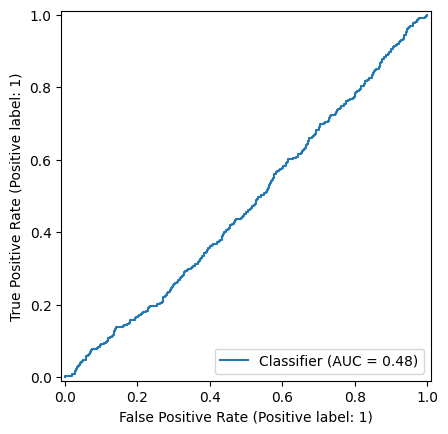

In [185]:
metrics.RocCurveDisplay.from_predictions(train_df['label'].to_numpy(), probs) 

## Logistic Regression

- move across the time series, fitting and evaluation as we go to learn what works and doesn't while we iterate on feature engineering 
- add regularization?
- add polynomial fit?

In [187]:
from sklearn.linear_model import LogisticRegression

In [190]:
train_df = train_df.join(account_df, how='left') 

In [191]:
X_train = train_df.drop(['label'], axis=1)

In [219]:
y_train = train_df['label']

<Axes: ylabel='account.id'>

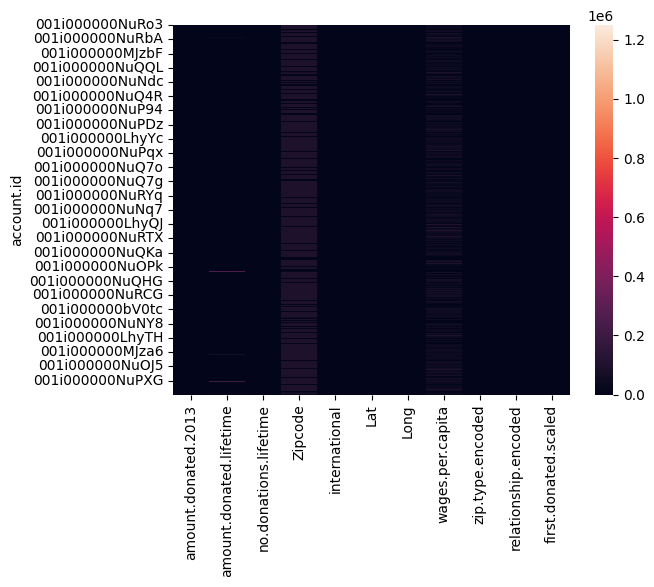

In [193]:
# Heatmap syntax for null values from https://stackoverflow.com/questions/53799537/seaborn-heatmap-from-pandas-dataframe-with-nans
sns.heatmap(X_train, mask=X_train.isnull())

In [195]:
X_train.head()

,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,Zipcode,international,Lat,Long,wages.per.capita,zip.type.encoded,relationship.encoded,first.donated.scaled
account.id,,,,,,,,,,,
001i000000NuRo3,0.0,0.0,0,0,0,0.00,0.00,0.000000,4,10,0.0
001i000000NuRxd,0.0,0.0,0,0,0,0.00,0.00,0.000000,4,10,0.0
001i000000NuQGN,0.0,0.0,0,94597,0,37.91,-122.07,38831.542145,2,10,0.0
001i000000NuPfL,0.0,0.0,0,94005,0,37.68,-122.41,45968.495972,2,10,0.0
001i000000NuQkP,0.0,0.0,0,94610,0,37.81,-122.24,41587.634136,2,10,0.0


In [196]:
y_train.head()

,label
account.id,
001i000000NuRo3,0
001i000000NuRxd,0
001i000000NuQGN,0
001i000000NuPfL,0
001i000000NuQkP,0


In [221]:
lr_model = LogisticRegression(penalty=None) 
fit(lr_model, X_train, y_train) 

/Users/jason/Local/school/520/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [261]:
lr_model.classes_

array([0, 1])

In [240]:
probs = predict_proba(lr_model, X_train)

In [256]:
positive_probs = probs[:,1]

In [262]:
metrics.roc_auc_score(y_t['label'], probs) 

ValueError: y should be a 1d array, got an array of shape (6941, 2) instead.

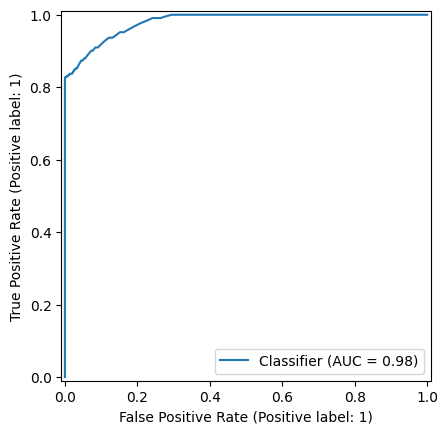

In [257]:
metrics.RocCurveDisplay.from_predictions(y_train.values, positive_probs) 

In [252]:
from sklearn.ensemble import RandomForestClassifier

In [254]:
rf_model = RandomForestClassifier()
fit(rf_model, X_train, y_train) 
probs = predict_proba(rf_model, X_train) 

In [258]:
positive_probs = probs[:, 1]

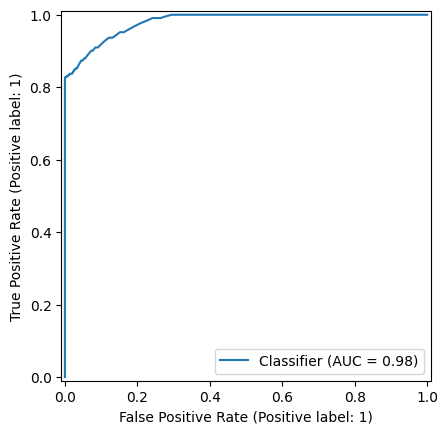

In [259]:
metrics.RocCurveDisplay.from_predictions(y_train.values, positive_probs)

## Submitting 

In [ ]:
sample_df = pd.read_csv('data/sample_submission.csv') 
sample_df.head()

In [ ]:
sample_df.shape